# Bernstein-Vazirani Algorithm

The Bernstein-Vazirani (BV) algorithm [[1](#DJWiki)], named after Ethan Bernstein and Umesh Vazirani, is a fundamental quantum algorithm that demonstrates a linear speed-up compared to its classical counterpart in the oracle complexity setting. While the BV algorithm showcases this theoretical speed-up, its practical utility is limited due to its specific problem domain. Nonetheless, it stands as one of the early examples illustrating the potential of quantum computing to outperform classical methods in certain scenarios.

**The algorithm addresses the following problem:**

- Given an $ n $-bit string $ x $ representing the input of a function $ f:\{0,1\}^n \rightarrow \{0,1\} $.
- $ f $ is a "quantum oracle function" (see NOTE) that takes an $ n $-bit string as input and returns the inner product of the input string and the "hidden bit string" $ s $: $ f(x) = x \cdot s $ for all $ x $, where the inner product is computed modulo 2.


Summing-up:

**Input:** $ x $, an $ n $-bit string.

**Promise:** There exists a hidden $ n $-bit string $ s $ such that $ f(x) = x \cdot s $ for all $ x $.

**Our Goal:** Determine the hidden bit string $ s $ using the minimal number of queries (evaluations) of the oracle function $ f $.

<details>
<summary> NOTE on oracle function</summary>
    
For the sake of this tutorial you could think of oracle function as "black-box" function, but we include here little elaboration:
    
The standard way [[2](#NielsenChuang)] of applying a classical function $f:\{0,1\}^n \rightarrow \{0,1\}$ on quantum states is with the oracle model: 
$\begin{equation}
O_f (\ket{x}_n\ket{y}_1) = \ket{x}_n\ket{y \oplus f(x)}_1
\end{equation}$
with $\ket{x}$ and $\ket{y}$ being the argument and target quantum states respectively, and $\oplus$ being affition modolu $2$, or the XOR operation. BV algorithm takes the oracle $O_f$ as an input, and performs the follwoing operation:
$\begin{equation}
\ket{x}\rightarrow (-1)^{f(x)}\ket{x}
\end{equation}$
This can obviously be applied on a superposition of states such that:
$\begin{equation}
\sum_{i=0}^{2^n-1}\alpha_i\ket{x_i}\rightarrow (-1)^{f(x_i)}\alpha_i\ket{x_i}
\end{equation}$
with $\alpha_i$ being the amplitude of the $\ket{x_i}$ state.

How this is happening? It's quite simple actually (hence the beuty of it), all needed is to apply the oracle $O_f$ on the state target quantum state $\ket{-}=\frac{1}{\sqrt{2}}\ket{0}-\frac{1}{\sqrt{2}}\ket{1}$ such that:
$\begin{equation}
O_f\ket{x}\ket{-} = (-1)^{f(x)}\ket{x}\ket{-}
\end{equation}$
and then effectively the desired transformation $\ket{x}\rightarrow (-1)^{f(x)}\ket{x}$ is achieved.

<div style="text-align:center;">
    <img src="https://classiq-docs-images.s3.amazonaws.com/phase_kickback_high_level.png" alt="Phase Kickback High Level" />
</div>
</details>

**The best classical solution** for this problem typically requires $ n $ evaluations of the function $ f $ to determine the hidden bit string $ s $. This scenario arises when the input bit string $ x $ consists of $ n-1 $ zeros and a single one, which systematically shifts across all positions in the string to explore all possible linear combinations. 

For example, the first evaluation would set $ x = 100...0 $, the second evaluation $ x = 010...0 $, and so on.

**In contrast to the classical solution, the quantum solution requires only single query!**

Let's see how this actually works! (Go to the [Mathemtaical Description](#mathematical-description) for full mathematical description)

**Classiq Concepts**
* [Within-Apply](htthttps://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/within-apply/?h=with)
* [Classical Control Flow (repeat, if_)](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/classical-control-flow/?h=repea#__tabbed_1_2)

## Guided Implementation

**The quantum solution that exploits the advantage goes by the following steps:**
1. Preper an uniform superposition in the input state $ x $ using `hadamard_transform`
2. `Apply` oracle function $ f $ `Within` $ \ket{-} $ 
3. Apply again uniform superposition on the registers of $ x $

The first and last steps could be easily done in the 'main' function using the Classiq's built-in" `hadamard_transform()`. The second step is the more complex one. Let's break it down, putting in mind that Classiq as in any proper devleoping platform, it is recomended **to think and design your code on the functional level in terms of functions**.

Directed by this note, we can implement one function at a time and then connect them. 

Let's start implementing! 

The main building-block in our implementation will use `within_apply`. This Classiq function performs the common quantum pattern: $ U^{\dagger}VU $.
This function contains two nested statement blocks, the compute block and the action block, and evaluates the sequence: compute ($ U $), action ($ V $), and invert(compute) ($ U^{\dagger} $).


<!-- The quantum objectsthat  are allocated and prepared by the compute block are subsequently un-computed and released. -->

By the Algorithm, $ U $ is chosen to be `prepare_minus` on auxiliary qubit, while $ V $ is the unitary oracle operator ($ O_f $) that implements the function  $ f $.

We start with the prepare $\ket{-}$ building block implemented with the `prepare_minus` function. It is implemented by sequentially applying the `X` (NOT) gate that transforms $\ket{0}$ into $X\ket{0}=\ket{1}$, and then applying the Hadamard `H` gate that takes the $\ket{1}$ state into the desired $H\ket{1}=\ket{-}$ state:

In [1]:
from classiq import H, Output, QBit, X, allocate, qfunc

@qfunc
def prepare_minus(target: Output[QBit]):
    allocate(out=target, num_qubits=1)
    X(target)
    H(target)

<div style="text-align:center;">
    <img src="https://classiq-docs-images.s3.amazonaws.com/phase_kickback_prepare_minus.gif" alt="Phase Kickback High Level" />
</div>

The next step would be implementing the oracle operator ($ O_f $) that implements the function  $ f $.

It is possible to implement $ O_f $ using auxiliary qubit that registers the value of $ f(x) $ by following this logic:
* For each $s_i =1$ we apply $ X $ gate on the auxiliary $ \ket{f} $, controlled by $ \ket{x_i} $.
* If $ s_i=0 $ we do nothing, which is equivalent to applying `IDENTITY` function.

<!-- $ \ket{f} $, initiated as $ \ket{f}=\ket{0} $, "sandwiched" within `prepare_minus`,and finally we  -->

In [2]:
from classiq import QParam, QArray, repeat, if_, CX, IDENTITY
from classiq.qmod.symbolic import floor

@qfunc
def oracle_function(s: QParam[int], x: QArray, res: QBit): 

    repeat(
        count=x.len,
        iteration=lambda i: if_(
            condition=floor(s / 2**i) % 2 == 1, then=lambda: CX(x[i], res), else_=lambda: IDENTITY(res)
        ))


* Here, the "oracle_function" employs the `repeat` construct to execute the logic described earlier $ n $ times (length of $ x $), as specified by the parameter 'count'.
* Within each iteration of the `repeat` loop, we utilize the `if_` statement, which parallels the conventional Python 'if' statement. It comprises the attributes: 'condition', 'then', and 'else_', which mirror the structure of an if-else statement in native Python.

Loops and conditions are the bread and butter of classical computation. In QMOD, the Classiq native language accessed through Classiq's Python SDK, we employ the same concepts with `repeat` and `if_` statements, serving as a means of **[Classical Control Flow](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/classical-control-flow/?h=repea#__tabbed_1_2)**. These are handy tools for describing reusable building blocks.

The 'condition' might look confusing in first glance, but actually all it does is implementing the above mentioned logic examining the value of $ s_i \in \{0,1\}$ in order to apply the appropriate gate.

Let's break it down:

1. $ \text{floor}(s / 2^i) $ divides the secret integer $ s $ by $ 2^i $, effectively shifting the bits of $ s $ $ i $ positions to the right in the binary representation.

2. Taking the result modulo 2 then extracts the rightmost bit of the resulting number.

3. If the extracted bit is 1, it indicates that the $ i $-th bit of the binary representation of $ s $ is indeed 1.

<!-- **To Validate! + Maybe to give little example? Another way to simplify this part**  -->

We are almost done! 
Now we have all we need in order to set 'bv_function' using `within_apply` as earlier discussed:

In [3]:
from classiq import within_apply

@qfunc
def bv_function(s: QParam[int], x: QArray):

    aux = QBit("aux")
    within_apply(lambda: prepare_minus(aux), lambda: oracle_function(s, x, aux))



Here, we begin by initializing an auxiliary qubit called "aux". Then, we leverage `within_apply` ([learn more](https://nightly.docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/within-apply/)), as previously discussed: $ U=$ prepare_minus(aux) and $ V=$f_logic(s, x, aux).

We received the above mentioned desired logic:


<div style="text-align:center;">
    <img src="https://classiq-docs-images.s3.amazonaws.com/oracle_function.gif" alt="oracle_function" />
</div>

Finally, Let's put all our buildin blocks together, in our main function:

In [4]:
from classiq import H, X, hadamard_transform

@qfunc
def main(x: Output[QArray]):
    
    allocate(STRING_LENGTH, x)
    
    hadamard_transform(x)
    bv_function(SECRET_INT, x)
    hadamard_transform(x)

Let's check what we have created!

In [5]:
# Input values:
SECRET_INT = 13  # We expect to get it as output
STRING_LENGTH = 5
NUM_SHOTS = 1


Note that number of shots can be set to 1, under the assumption of noiseless execution!

In [6]:
# Making sure our input makes sense:
import numpy as np

assert (
    np.floor(np.log2(SECRET_INT) + 1) <= STRING_LENGTH
), "The STRING_LENGTH cannot be smaller than secret string length"

Execution:

In [10]:
from classiq import create_model, synthesize, show, execute, set_execution_preferences
from classiq.execution import ExecutionPreferences 

# Creating model, using `ExecutionPreferences` of our desired number of shots:
execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
# qmod = set_execution_preferences(qmod, execution_preferences)
qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

# Synthesizing optimized circuit (quantum program) out of our model at Classiq's backend:
qprog = synthesize(qmod)

# Showing the quantum program using Classiq's visualizer 
show(qprog)

Opening: https://platform.classiq.io/circuit/937eb016-f50a-444c-a071-00dad7eceedf?version=0.39.0


Before executing our program and making sure it’s actually works, play with Classiq's super cool visualization tool!
It's very convenient to see the defrent building blocks and hierarchies in the program.

<div style="text-align:center;">
    <img src="https://classiq-docs-images.s3.amazonaws.com/vis_tool.gif" alt="vis_tool" />
</div>

Now let's varify that our quantum program actually does what we expect it to do!

Execution with one shot yields:

In [13]:
# Execute the quantum program and access the result
job = execute(qprog)

In [14]:
res = execute(qprog).result()
secret_integer_q = res[0].value.parsed_counts[0].state["x"]

print("The secret integer is:", secret_integer_q)
print(
    "The probability for measuring the secret integer is:",
    res[0].value.parsed_counts[0].shots / NUM_SHOTS)

The secret integer is: 13.0
The probability for measuring the secret integer is: 1.0


**We received the expected result!**

Using only one approximation of the function, we demonstrated the hidden power within quantum computation. \
As mentioned before, the best classical calculation would have take `STRING_LENGTH` approximations to classical computer.

We could also execute using the platform's GUI. After setting the number of shots and executing, we would receive:

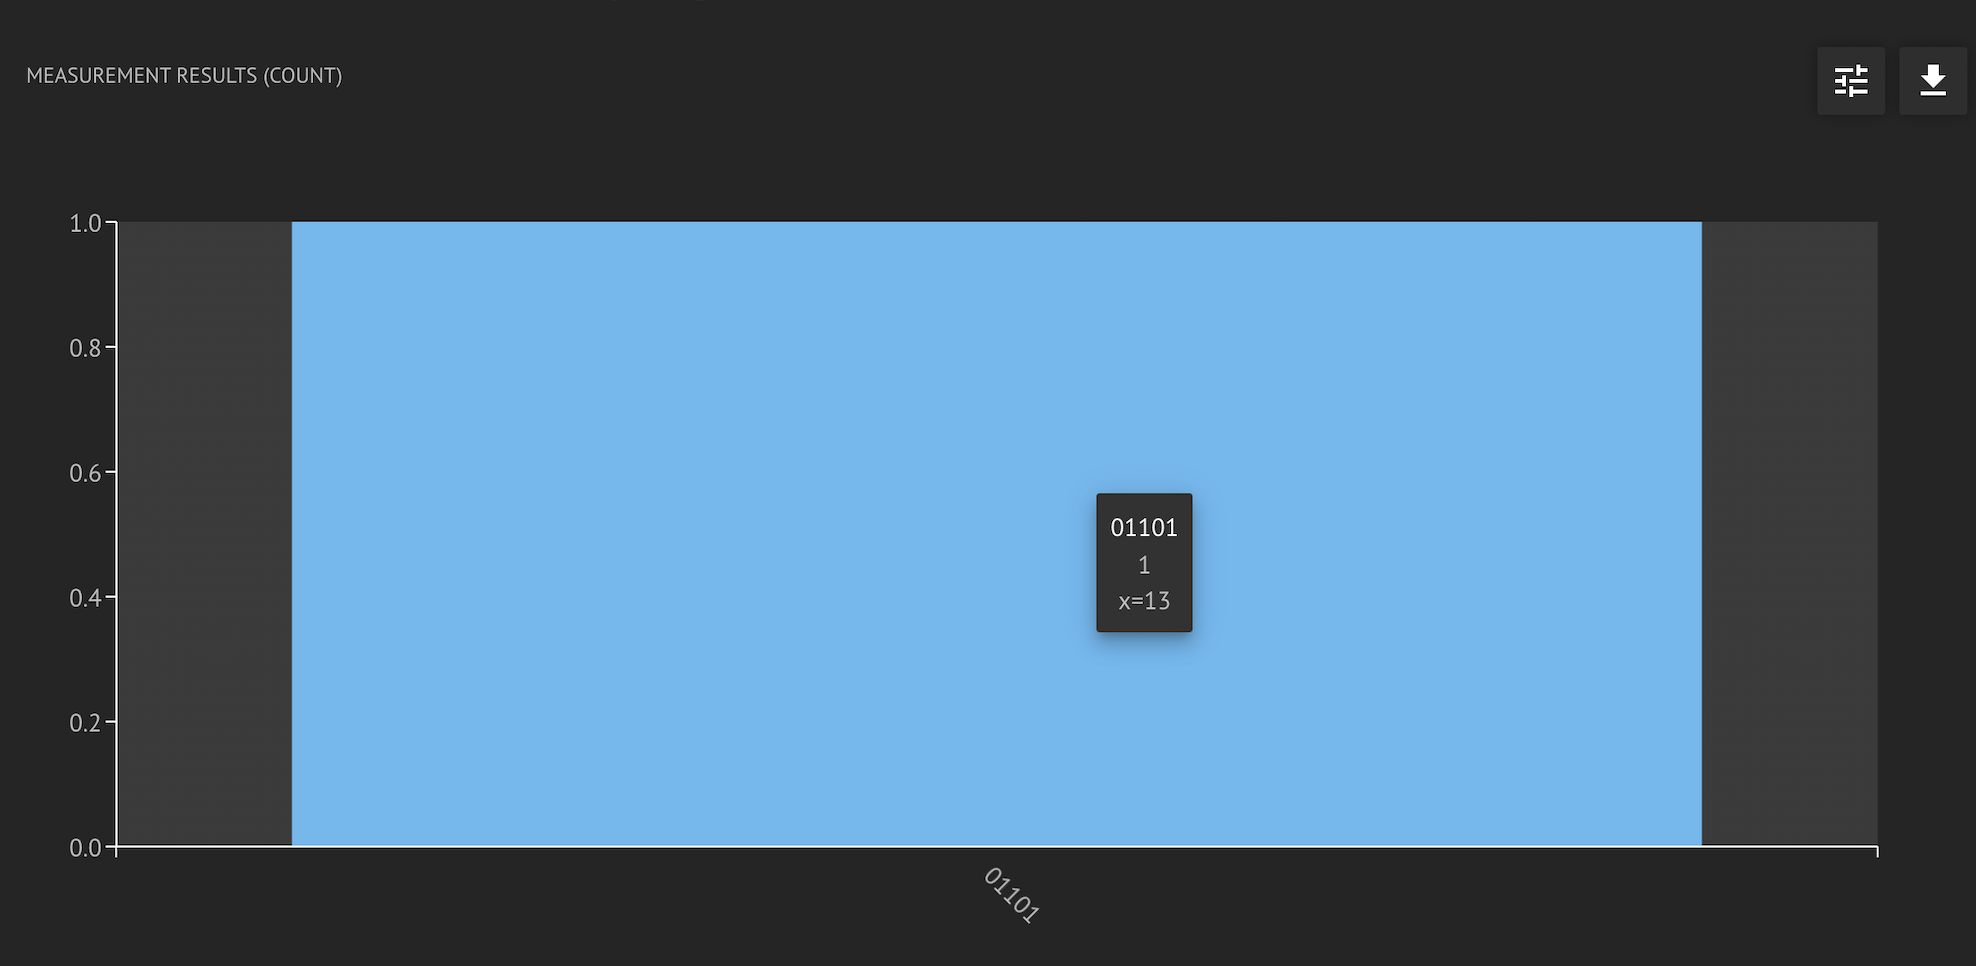

Or if you want to explore the execution after running it from the notebook:

In [15]:
job.open_in_ide()

## Mathematical Description

Here's the Bernstein-Vazirani algorithm described mathematically:

Our starting point is by definition the $ n $ dimensional zero state:

$$
\ket{0}^{\otimes n} =\ket{00 . . . 0}
$$

The first step in the algorithm is to apply a Hadamard gate to each qubit:

$$
H^{\otimes n} \ket{0}^{\otimes n} = \ket{+}^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} \ket{x} \equiv \ket{X}
$$

When $ \ket{x} $ is the integers basis in binary representation.

Then, we apply the oracle $ O_f $ by definition:

$$
O_f (\ket{x}\ket{-}) =\frac{1}{\sqrt2}[O_f(\ket{x}\ket{0})-O_f(\ket{x}\ket{1})] =(-1)^{f(x)}\ket{x}\ket{-}
$$

The state $\ket{-}$ is the state of the auxiliary qubit in our code. The value of $f(x)$, $1$ or $0$ determine whether there is phase flip or not correspondingly.

<!-- Check also the NOTE at the beginning of the notebook and the quantum oracle tutorial (**To Add**). -->

We actually apply the oracle on the state $\ket{X}$, and not on the superposition component $\ket{x}$, so we get the state:

$$
\ket{-}(-1)^{f(x)} \ket{X}  = \ket{-}(-1)^{f(x)} \frac{1}{\sqrt{2^n}}  \sum_{x \in \{0,1\}^n} \ket{x}
$$

Now after applying the oracle, we apply Hadamard gates again to each qubit except the auxiliary qubit which could be left aside:

$$
H^{\otimes n} (-1)^{f(x)} \frac{1}{\sqrt{2^n}}  \sum_{x \in \{0,1\}^n} \ket{x} = (-1)^{f(x)} \frac{1}{\sqrt{2^n}}  \sum_{x \in \{0,1\}^n} H^{\otimes n}\ket{x}
=  \frac{1}{2^n} \sum_{x,y\in \{0,1\}^n} (-1)^{f(x)+x \cdot y} \ket{y} =  \frac{1}{2^n} \sum_{x,y\in \{0,1\}^n} (-1)^{x \cdot (s \oplus y)} \ket{y} \equiv \ket{s}
$$

We obtain $ \ket{s} $ because for each $ \ket{y} $, the coefficient is equal to 1 only if $ s \oplus y = \vec{0} $. Otherwise, the coefficient is 0.

Note that $ s \oplus y = \vec{0} $ occurs only when $ s = y $, meaning only one component contributes to the sum. This component is $ \ket{y} = \ket{s} $ with a coefficient of 1.


## All Code Together

Python version:

In [ ]:
# BV From git:
from classiq import *
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import floor



@qfunc
def prepare_minus(target: Output[QBit]):
    allocate(out=target, num_qubits=1)
    X(target)
    H(target)


@qfunc
def bv_predicate(a: QParam[int], x: QArray, res: QBit):

    repeat(
        x.len,
        lambda i: if_(
            floor(a / 2**i) % 2 == 1, lambda: CX(x[i], res), lambda: IDENTITY(res)
        ),
    )




@qfunc
def bv_function(a: QParam[int], x: QArray):

    aux = QBit("aux")
    within_apply(
        lambda: prepare_minus(aux), lambda: bv_predicate(a, x, aux)
    )

SECRET_INT = 5
STRING_LENGTH = 5
NUM_SHOTS = 1000


@qfunc
def main(x: Output[QArray]):
    allocate(STRING_LENGTH, x)
    hadamard_transform(x)
    bv_function(SECRET_INT, x)
    hadamard_transform(x)

qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)
qprog = synthesize(qmod)
show(qprog)

Native QMOD version:


```
// Bernstein-Vazirani Algorithm 

qfunc bv_predicate<a: int>(x: qbit[], res: qbit) {

repeat<len(x), lambda<index>() {

if<(floor(a / (2 ** index)) % 2) == 1, lambda() {

CX(x[0 + (index):(0 + (index)) + 1], res);

}, lambda() {

IDENTITY(res);

}>();

}>();

}

qfunc bv_function<a: int>(x: qbit[]) {

aux: qbit;

hadamard_transform(x);

within {

allocate<1>(aux);

X(aux);

H(aux);

} apply {

bv_predicate<a>(x, aux);

}

hadamard_transform(x);

}

qfunc main(output x: qbit[]) {

allocate<5>(x);

bv_function<13>(x);

}


```

## References

<a id='DJWiki'>[1]</a>: [Bernstein–Vazirani algorithm (Wikipedia)](https://en.wikipedia.org/wiki/Bernstein%E2%80%93Vazirani_algorithm)

<a id='Nielsen&Chunag'>[2]</a>: [Quantum Computation and Quantum Information (Michael Nielsen and Isaac Chuang)](https://en.wikipedia.org/wiki/Quantum_Computation_and_Quantum_Information)

<a id='Wolf'>[3]</a>: [Quantum Computing:
Lecture Notes (Ronald de Wolf)](https://homepages.cwi.nl/~rdewolf/qcnotes.pdf)

